<a href="https://colab.research.google.com/github/BarhaPritha/Data-Engineering-of-Rest-Countries-API/blob/main/Rest_Countries.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


==== Countries ====
  code                 name           capital     continents  population        area  density                            borders weekStart                                                                               timezones
0  AFG          Afghanistan             Kabul           Asia    40218234    652230.0    61.66       IRN, PAK, TKM, UZB, TJK, CHN    Monday                                                                               UTC+04:30
1  ALB              Albania            Tirana         Europe     2837743     28748.0    98.71                 MNE, GRC, MKD, UNK    Monday                                                                               UTC+01:00
2  DZA              Algeria           Algiers         Africa    44700000   2381741.0    18.77  TUN, LBY, NER, ESH, MRT, MLI, MAR    Sunday                                                                               UTC+01:00
3  ASM       American samoa         Pago pago        Oceania       5519

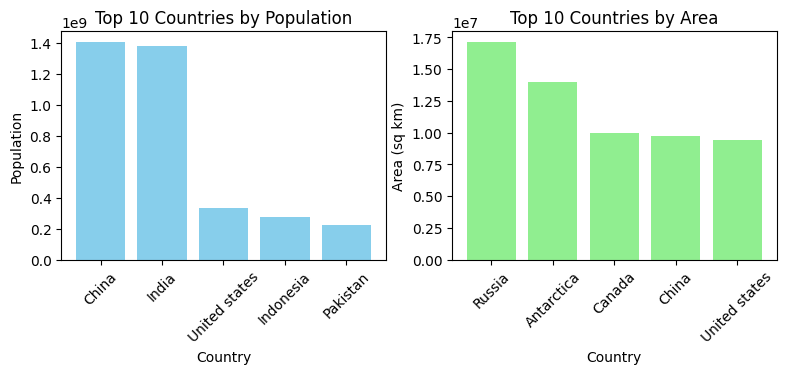

In [34]:
"""
Author: Barha Meherun Pritha

Dataset: REST Countries API with selected fields
https://restcountries.com/v3.1/all?fields=cca3,name,capital,continents,languages,area,borders,population,startOfWeek,timezones

Fields extracted: cca3, name.common, capital, continents, languages, area, borders, population, startOfWeek, timezones
"""


import os
import sys
import logging
import sqlite3
import requests
import pandas as pd
from typing import List, Dict, Any
import matplotlib.pyplot as plt


logging.basicConfig(level=logging.INFO, format="%(asctime)s [%(levelname)s] %(message)s")
logger = logging.getLogger(__name__)


API_URL = os.getenv("REST_COUNTRIES_URL", "https://restcountries.com/v3.1/all?fields=cca3,name,capital,continents,languages,area,borders,population,startOfWeek,timezones")
DB_PATH = os.getenv("DB_PATH", "data.db")



def extract() -> List[Dict[str, Any]]:
    try:
        logger.info(f"Extract: requesting data from API")
        resp = requests.get(API_URL, timeout=15)
        resp.raise_for_status()
        return resp.json()
    except Exception as e:
        logger.warning(f"API request failed: {e}.")
        sys.exit(1)


def transform(data: List[Dict[str, Any]]):
    countries, languages, country_languages = [], {}, []

    for country in data:
        code = country.get("cca3").upper()
        if not code:
            continue

        name = country.get("name", {}).get("common", "").capitalize()
        capital = ", ".join(country.get("capital") or []).capitalize()
        continents = ", ".join(country.get("continents") or []).capitalize()
        population = int(country.get("population") or 0)
        area = float(country.get("area") or 0.0)
        density = round(population / area, 2) if area else None
        borders = ", ".join(country.get("borders") or []).upper()
        weekStart = country.get("startOfWeek", "").capitalize()
        timezones = ", ".join(country.get("timezones") or [])

        countries.append({
            "code": code,
            "name": name,
            "capital": capital,
            "continents": continents,
            "population": population,
            "area": area,
            "density": density,
            "borders": borders,
            "weekStart": weekStart,
            "timezones": timezones
        })

        for languageCode, lname in (country.get("languages") or {}).items():
            languages[languageCode] = lname.capitalize()
            country_languages.append((code, languageCode))

    logger.info(f"Transform: {len(countries)} countries, {len(languages)} languages total")
    return countries, languages, country_languages



def load(countries, languages, country_languages, db_path=DB_PATH):
    try:
        conn = sqlite3.connect(db_path)
        cur = conn.cursor()

        cur.executescript("""
        CREATE TABLE IF NOT EXISTS countries (
            code TEXT PRIMARY KEY,
            name TEXT,
            capital TEXT,
            continents TEXT,
            population INTEGER,
            area REAL,
            density REAL,
            borders TEXT,
            weekStart TEXT,
            timezones TEXT
        );
        CREATE TABLE IF NOT EXISTS languages (
            languageCode TEXT PRIMARY KEY,
            name TEXT
        );
        CREATE TABLE IF NOT EXISTS country_languages (
            code TEXT,
            languageCode TEXT,
            PRIMARY KEY (code, languageCode),
            FOREIGN KEY (code) REFERENCES countries(code),
            FOREIGN KEY (languageCode) REFERENCES languages(languageCode)
        );
        """)

        cur.executemany("""
        INSERT OR REPLACE INTO countries
        (code, name, capital, continents, population, area, density, borders, weekStart, timezones)
        VALUES (:code, :name, :capital, :continents, :population, :area, :density, :borders, :weekStart, :timezones)
        """, countries)

        cur.executemany("INSERT OR REPLACE INTO languages (languageCode, name) VALUES (?, ?)", languages.items())
        cur.executemany("INSERT OR REPLACE INTO country_languages (code, languageCode) VALUES (?, ?)", country_languages)

        conn.commit()
        conn.close()
        logger.info(f"Load: {db_path} is updated.")

    except Exception as e:
        logger.warning(f"Database connection failed: {e}.")



def preview_tables(db_path=DB_PATH):
    conn = sqlite3.connect(db_path)
    countries = pd.read_sql_query("SELECT * FROM countries ORDER BY name LIMIT 10;", conn)
    languages = pd.read_sql_query("SELECT * FROM languages ORDER BY name LIMIT 10;", conn)
    country_languages = pd.read_sql_query("SELECT * FROM country_languages ORDER BY code LIMIT 10;", conn)
    conn.close()

    print("\n==== Countries ====")
    print(countries.to_string(index=True), "\n")
    print("\n==== Languages ====")
    print(languages.to_string(index=True), "\n")
    print("\n==== Countries and their Languages ====")
    print(country_languages.to_string(index=True), "\n")


def run_summary(db_path=DB_PATH):
    conn = sqlite3.connect(db_path)

    df_pop = pd.read_sql_query("SELECT name, population FROM countries WHERE population IS NOT NULL ORDER BY population DESC LIMIT 5;", conn)
    df_area = pd.read_sql_query("SELECT name, area FROM countries WHERE area IS NOT NULL ORDER BY area DESC LIMIT 5;", conn)
    conn.close()

    print("\n==== Top 5 Countries by Population ====")
    print(df_pop.to_string(index=True), "\n")
    print("\n==== Top 5 Countries by Area ====")
    print(df_area.to_string(index=True), "\n")

    fig, axes = plt.subplots(1, 2, figsize=(8, 4))

    axes[0].bar(df_pop["name"], df_pop["population"], color="skyblue")
    axes[0].set_title("Top 10 Countries by Population")
    axes[0].set_xlabel("Country")
    axes[0].set_ylabel("Population")
    axes[0].tick_params(axis="x", rotation=45)

    axes[1].bar(df_area["name"], df_area["area"], color="lightgreen")
    axes[1].set_title("Top 10 Countries by Area")
    axes[1].set_xlabel("Country")
    axes[1].set_ylabel("Area (sq km)")
    axes[1].tick_params(axis="x", rotation=45)

    plt.tight_layout()
    plt.show()



def main():
    raw = extract()
    countries, languages, country_languages = transform(raw)
    load(countries, languages, country_languages)

    preview_tables()
    run_summary()



if __name__ == "__main__":
    main()
